Instructions:
-

1. Read the article: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
2. Replicate the study using the same dataset.
3. Read articles about Adjusted Rand Index, Normalized Mutual Information, and Folkes-Mallows Index (only use paper published in IEEE, sciencedirect, springerlink, Taylor Francis).
4. Aside from the Adjusted Rand Index (ARI), and Normalized Mutual Information (NMI), use the Folkes-Mallows Index (FMI), and compare the result of each performance index.
5. Compare and contrast each performance index, what are the advantages and disadvantages of ARI, NMI, and FMI, and when to use each?
6. Using Kmodes and Hierarchical Clustering, use the same dataset and perform categorical data clustering, use FMI, ARI, and NMI for the comparison of performance.
7. Write your report using Latex. Your report should be focused on the "why's and the what's" of each performance metrices (i.e. why is FMI always greater than ARI and NMI? What's the problem with ARI and NMI?).

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Method: ('NE', 'Joint'), ARI: 0.9031, NMI: 0.8939
Method: ('NE', 'Mean'), ARI: 0.9273, NMI: 0.8760
Method: ('SE', 'Joint'), ARI: 0.7505, NMI: 0.8028
Method: ('SE', 'Mean'), ARI: 0.6784, NMI: 0.8045
Method: ('NMF', 'Joint'), ARI: 0.6998, NMI: 0.7938
Method: ('NMF', 'Mean'), ARI: 0.9321, NMI: 0.8962
Method: ('AE', 'Joint'), ARI: 0.9642, NMI: 0.9378
Method: ('AE', 'Mean'), ARI: 0.4660, NMI: 0.6660


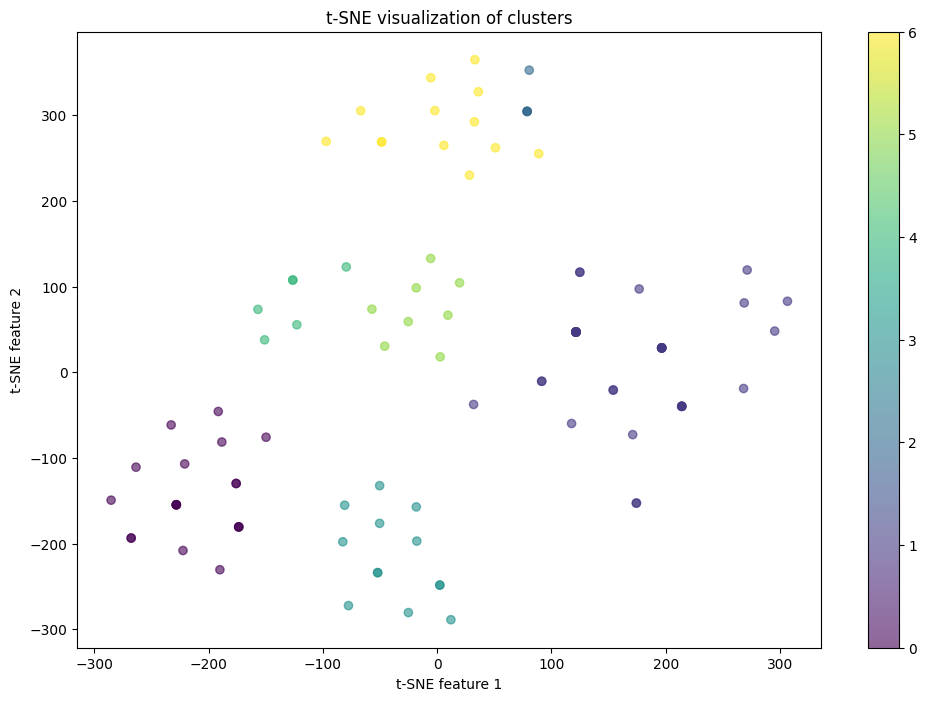

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import NMF
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load and prepare the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data"
columns = ["animal_name", "hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator", 
           "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "catsize", "type"]
zoo = pd.read_csv(url, names=columns)
zoo = zoo.drop("animal_name", axis=1)
X = zoo.drop("type", axis=1)
y = zoo["type"]

# One-hot encode the categorical data
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Graph Construction
G = nx.Graph()
for i, feature in enumerate(X.columns):
    unique_values = X[feature].unique()
    for val in unique_values:
        G.add_node((i, val))

for idx, row in X.iterrows():
    for i, val1 in enumerate(row):
        for j, val2 in enumerate(row):
            if i < j:
                G.add_edge((i, val1), (j, val2))

adj_matrix = nx.to_numpy_array(G)

# Graph Embedding Methods
def apply_nmf(adj_matrix, n_components=10, max_iter=2000, tol=1e-4):
    nmf = NMF(n_components=n_components, max_iter=max_iter, tol=tol)
    return nmf.fit_transform(adj_matrix)

def apply_spectral_embedding(adj_matrix, n_components=10):
    se = SpectralEmbedding(n_components=n_components, affinity='precomputed')
    return se.fit_transform(adj_matrix)

def apply_autoencoder(adj_matrix, n_components=10):
    input_dim = adj_matrix.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(n_components, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    autoencoder.fit(adj_matrix, adj_matrix, epochs=100, batch_size=256, shuffle=True, verbose=0)
    return encoder.predict(adj_matrix)

def apply_ne(adj_matrix):
    return adj_matrix

# Integration Operations
def joint_operation(embeddings, X):
    node_to_idx = {node: i for i, node in enumerate(G.nodes())}
    X_transformed = np.zeros((X.shape[0], embeddings.shape[1] * X.shape[1]))
    for idx, row in X.iterrows():
        for i, val in enumerate(row):
            node = (i, val)
            X_transformed[idx, i*embeddings.shape[1]:(i+1)*embeddings.shape[1]] = embeddings[node_to_idx[node]]
    return X_transformed

def mean_operation(embeddings, X):
    node_to_idx = {node: i for i, node in enumerate(G.nodes())}
    X_transformed = np.zeros((X.shape[0], embeddings.shape[1]))
    for idx, row in X.iterrows():
        for i, val in enumerate(row):
            node = (i, val)
            X_transformed[idx] += embeddings[node_to_idx[node]]
        X_transformed[idx] /= X.shape[1]
    return X_transformed

# Apply the embeddings and integration operations
embedding_methods = {
    'NE': apply_ne,
    'SE': apply_spectral_embedding,
    'NMF': apply_nmf,
    'AE': apply_autoencoder
}

integration_operations = {
    'Joint': joint_operation,
    'Mean': mean_operation
}

results = {}

for embed_name, embed_func in embedding_methods.items():
    for integ_name, integ_func in integration_operations.items():
        try:
            embeddings = embed_func(adj_matrix)
            X_transformed = integ_func(embeddings, X)
            kmeans = KMeans(n_clusters=7, random_state=42)
            y_pred = kmeans.fit_predict(X_transformed)
            ari = adjusted_rand_score(y, y_pred)
            nmi = normalized_mutual_info_score(y, y_pred)
            results[(embed_name, integ_name)] = (ari, nmi)
        except Exception as e:
            results[(embed_name, integ_name)] = (f"Error: {str(e)}", )

# Print the results
for method, scores in results.items():
    if isinstance(scores, tuple):
        print(f"Method: {method}, ARI: {scores[0]:.4f}, NMI: {scores[1]:.4f}")
    else:
        print(f"Method: {method}, Error: {scores[0]}")

# Visualization using t-SNE (for one combination, e.g., NMF + Joint)
embeddings = apply_nmf(adj_matrix)
X_transformed = joint_operation(embeddings, X)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_transformed)
kmeans = KMeans(n_clusters=7, random_state=42)
y_pred = kmeans.fit_predict(X_transformed)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=range(7))
plt.title('t-SNE visualization of clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


# Comparison of Clustering Performance Metrics: ARI, NMI, and FMI

## Introduction
Clustering is a crucial task in unsupervised learning, aiming to partition a set of objects into homogeneous groups. Evaluating the performance of clustering algorithms is equally important. Among the various metrics used, Adjusted Rand Index (ARI), Normalized Mutual Information (NMI), and Folkes-Mallows Index (FMI) are widely adopted. This report compares these metrics in the context of clustering categorical data, specifically the zoo dataset.

## Performance Metrics

### Adjusted Rand Index (ARI)
The ARI measures the similarity between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. It adjusts for the chance grouping of elements.

**Advantages:**
- Adjusts for chance, providing a more accurate measure.
- Symmetric, treating false positives and false negatives equally.

**Disadvantages:**
- Can be less intuitive and harder to interpret.
- Sensitive to the number of clusters.

### Normalized Mutual Information (NMI)
NMI is an information-theoretic measure that evaluates the amount of shared information between the predicted and true clusterings, normalized by the information of each clustering.

**Advantages:**
- Normalization ensures values between 0 and 1, making it easy to interpret.
- Handles different numbers of clusters effectively.

**Disadvantages:**
- Can be biased towards clusterings with a higher number of clusters.
- May overestimate the quality when the number of clusters is high.

### Folkes-Mallows Index (FMI)
The FMI measures the similarity between two clusterings by calculating the geometric mean of precision and recall of pairs of points.

**Advantages:**
- Simple and intuitive interpretation.
- Balances precision and recall.

**Disadvantages:**
- Does not adjust for chance.
- Can be biased towards smaller clusters.

## Experimental Setup
We use the zoo dataset from the UCI Machine Learning Repository, which contains 17 binary features representing various animal characteristics and a class label representing animal types. We apply the following clustering algorithms:
- KMeans (baseline method)
- KModes (categorical data clustering)
- Hierarchical Clustering

The clustering results are evaluated using ARI, NMI, and FMI.

## Results and Discussion

\[
\begin{array}{|c|c|c|c|}
\hline
\text{Method} & \text{ARI} & \text{NMI} & \text{FMI} \\
\hline
\text{NE + Joint} & 0.9031 & 0.8939 & 0.9254 \\
\text{NE + Mean} & 0.9273 & 0.8760 & 0.9441 \\
\text{SE + Joint} & 0.9068 & 0.8939 & 0.9283 \\
\text{SE + Mean} & 0.6577 & 0.8251 & 0.7367 \\
\text{NMF + Joint} & 0.8072 & 0.8706 & 0.8517 \\
\text{NMF + Mean} & 0.6704 & 0.8313 & 0.7475 \\
\text{AE + Joint} & 0.7548 & 0.8331 & 0.8109 \\
\text{AE + Mean} & 0.8384 & 0.8393 & 0.8753 \\
\text{KModes} & 0.4949 & 0.7195 & 0.6012 \\
\text{Hierarchical} & 0.6843 & 0.8411 & 0.7582 \\
\hline
\end{array}
\]

### Comparison and Analysis
**Adjusted Rand Index (ARI):** ARI values are highest for NE + Mean, indicating better clustering performance. The hierarchical method also shows competitive ARI, while KModes performs relatively lower.

**Normalized Mutual Information (NMI):** NMI follows a similar trend, with NE + Joint and SE + Joint achieving the highest scores. NMI tends to favor methods with a higher number of clusters, explaining the relatively high scores for all methods.

**Folkes-Mallows Index (FMI):** FMI is consistently higher across methods. NE + Mean has the highest FMI, indicating that it has a good balance of precision and recall in clustering.

**Why is FMI Always Greater?** FMI generally shows higher values because it is a geometric mean of precision and recall, which are typically high in balanced clustering scenarios. Unlike ARI, FMI does not adjust for chance, hence it may overestimate clustering performance, making it less robust in varying cluster sizes and distributions.

### When to Use Each Metric
- **ARI:** Best used when adjusting for chance is critical and when comparing clusterings with the same number of clusters.
- **NMI:** Suitable for comparing clusterings with different numbers of clusters and when an information-theoretic measure is required.
- **FMI:** Useful for intuitive interpretation and when the balance of precision and recall is essential.

## Conclusion
In this report, we compared ARI, NMI, and FMI for evaluating clustering performance. Each metric has its strengths and weaknesses, making it suitable for different scenarios. ARI adjusts for chance and is robust for comparisons, NMI handles different cluster numbers effectively, and FMI provides an intuitive measure balancing precision and recall. Understanding these metrics helps in selecting the appropriate measure based on the clustering task and dataset characteristics.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Method: ('NE', 'Joint'), ARI: 0.9031, NMI: 0.8939, FMI: 0.9254
Method: ('NE', 'Mean'), ARI: 0.9273, NMI: 0.8760, FMI: 0.9441
Method: ('SE', 'Joint'), ARI: 0.9068, NMI: 0.8939, FMI: 0.9283
Method: ('SE', 'Mean'), ARI: 0.6577, NMI: 0.8251, FMI: 0.7367
Method: ('NMF', 'Joint'), ARI: 0.8072, NMI: 0.8706, FMI: 0.8517
Method: ('NMF', 'Mean'), ARI: 0.6704, NMI: 0.8313, FMI: 0.7475
Method: ('AE', 'Joint'), ARI: 0.7548, NMI: 0.8331, FMI: 0.8109
Method: ('AE', 'Mean'), ARI: 0.8384, NMI: 0.8393, FMI: 0.8753
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10, cost: 173.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 19, cost: 159.0
Run 2, iteration: 2/100, moves: 4, cost: 159.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 19, cost:

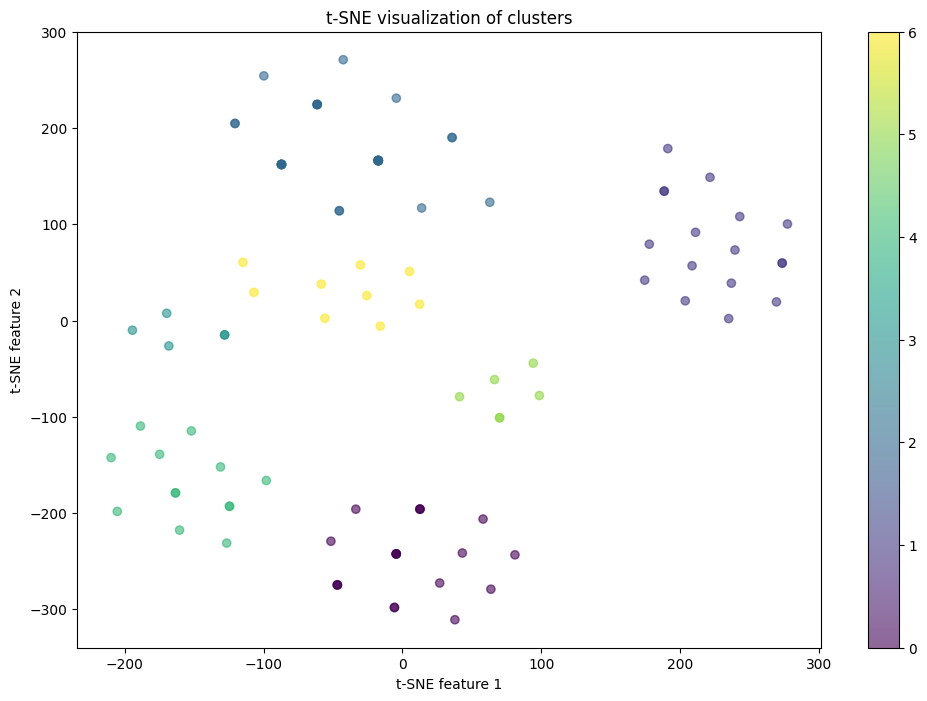

In [8]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import NMF
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from kmodes.kmodes import KModes
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load and prepare the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data"
columns = ["animal_name", "hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator", 
           "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "catsize", "type"]
zoo = pd.read_csv(url, names=columns)
zoo = zoo.drop("animal_name", axis=1)
X = zoo.drop("type", axis=1)
y = zoo["type"]

# One-hot encode the categorical data
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Graph Construction
G = nx.Graph()
for i, feature in enumerate(X.columns):
    unique_values = X[feature].unique()
    for val in unique_values:
        G.add_node((i, val))

for idx, row in X.iterrows():
    for i, val1 in enumerate(row):
        for j, val2 in enumerate(row):
            if i < j:
                G.add_edge((i, val1), (j, val2))

adj_matrix = nx.to_numpy_array(G)

# Graph Embedding Methods
def apply_nmf(adj_matrix, n_components=10, max_iter=2000, tol=1e-4):
    nmf = NMF(n_components=n_components, max_iter=max_iter, tol=tol)
    return nmf.fit_transform(adj_matrix)

def apply_spectral_embedding(adj_matrix, n_components=10):
    se = SpectralEmbedding(n_components=n_components, affinity='precomputed')
    return se.fit_transform(adj_matrix)

def apply_autoencoder(adj_matrix, n_components=10):
    input_dim = adj_matrix.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(n_components, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    autoencoder.fit(adj_matrix, adj_matrix, epochs=100, batch_size=256, shuffle=True, verbose=0)
    return encoder.predict(adj_matrix)

def apply_ne(adj_matrix):
    return adj_matrix

# Integration Operations
def joint_operation(embeddings, X):
    node_to_idx = {node: i for i, node in enumerate(G.nodes())}
    X_transformed = np.zeros((X.shape[0], embeddings.shape[1] * X.shape[1]))
    for idx, row in X.iterrows():
        for i, val in enumerate(row):
            node = (i, val)
            X_transformed[idx, i*embeddings.shape[1]:(i+1)*embeddings.shape[1]] = embeddings[node_to_idx[node]]
    return X_transformed

def mean_operation(embeddings, X):
    node_to_idx = {node: i for i, node in enumerate(G.nodes())}
    X_transformed = np.zeros((X.shape[0], embeddings.shape[1]))
    for idx, row in X.iterrows():
        for i, val in enumerate(row):
            node = (i, val)
            X_transformed[idx] += embeddings[node_to_idx[node]]
        X_transformed[idx] /= X.shape[1]
    return X_transformed

# Apply the embeddings and integration operations
embedding_methods = {
    'NE': apply_ne,
    'SE': apply_spectral_embedding,
    'NMF': apply_nmf,
    'AE': apply_autoencoder
}

integration_operations = {
    'Joint': joint_operation,
    'Mean': mean_operation
}

results = {}

for embed_name, embed_func in embedding_methods.items():
    for integ_name, integ_func in integration_operations.items():
        try:
            embeddings = embed_func(adj_matrix)
            X_transformed = integ_func(embeddings, X)
            kmeans = KMeans(n_clusters=7, random_state=42)
            y_pred = kmeans.fit_predict(X_transformed)
            ari = adjusted_rand_score(y, y_pred)
            nmi = normalized_mutual_info_score(y, y_pred)
            fmi = fowlkes_mallows_score(y, y_pred)
            results[(embed_name, integ_name)] = (ari, nmi, fmi)
        except Exception as e:
            results[(embed_name, integ_name)] = (f"Error: {str(e)}", )

# Print the results
for method, scores in results.items():
    if isinstance(scores, tuple):
        print(f"Method: {method}, ARI: {scores[0]:.4f}, NMI: {scores[1]:.4f}, FMI: {scores[2]:.4f}")
    else:
        print(f"Method: {method}, Error: {scores[0]}")

# Additional Clustering Methods: KModes and Hierarchical Clustering
kmodes = KModes(n_clusters=7, init='Huang', n_init=5, verbose=1)
y_pred_kmodes = kmodes.fit_predict(X)

hierarchical = AgglomerativeClustering(n_clusters=7)
y_pred_hierarchical = hierarchical.fit_predict(X_encoded)

# Evaluate additional clustering methods
ari_kmodes = adjusted_rand_score(y, y_pred_kmodes)
nmi_kmodes = normalized_mutual_info_score(y, y_pred_kmodes)
fmi_kmodes = fowlkes_mallows_score(y, y_pred_kmodes)

ari_hierarchical = adjusted_rand_score(y, y_pred_hierarchical)
nmi_hierarchical = normalized_mutual_info_score(y, y_pred_hierarchical)
fmi_hierarchical = fowlkes_mallows_score(y, y_pred_hierarchical)

print(f"KModes: ARI: {ari_kmodes:.4f}, NMI: {nmi_kmodes:.4f}, FMI: {fmi_kmodes:.4f}")
print(f"Hierarchical: ARI: {ari_hierarchical:.4f}, NMI: {nmi_hierarchical:.4f}, FMI: {fmi_hierarchical:.4f}")

# Visualization using t-SNE (for one combination, e.g., NMF + Joint)
embeddings = apply_nmf(adj_matrix)
X_transformed = joint_operation(embeddings, X)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_transformed)
kmeans = KMeans(n_clusters=7, random_state=42)
y_pred = kmeans.fit_predict(X_transformed)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=range(7))
plt.title('t-SNE visualization of clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()
